# Random Data as Input
Having a range of data, given the limits of position and velocity, generate uniform random data using the made up library of functions

In [1]:
import integrate_data as intd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import torch

In [2]:
#input of global program (data about our network)
N_layers = 50
dt = 1e-3

name = "exp_random_data"

#comparission for post processing
xreal, epsilon = 0.0, 1e-1

# function for the differential equation
k = 1
def force_function(x):
    return - k * x * x

def f_dottz(t, z):
    """function in the differential equation"""
    x, v = z
    dzdt = [v, force_function(x)]
    return dzdt

In [3]:
#input of program
xlow, xhigh = -5.0, 5.0
vlow, vhigh = -10.0, 20.0
N_samples = 1000

In [4]:
# inner definitions of the program
xlimits = [xlow, xhigh]
vlimits = [vlow, vhigh]
# the first tuple is low limits for both
limits = list(zip(xlimits, vlimits))


# where we save the data information
global_data = []

In [5]:
random_xv = np.random.uniform(low=limits[0], high=limits[1], size=(N_samples,2))

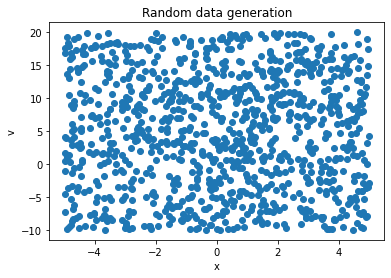

In [6]:
# plotting of the distribution
plt.scatter(random_xv[:,0], random_xv[:,1])
plt.xlabel('x')
plt.ylabel('v')
plt.title("Random data generation")
plt.show()

In [7]:
for k_data in range(N_samples):
    # generate the series with the inputs
    xi = random_xv[k_data][0]
    vi = random_xv[k_data][1]

    arguments = intd.make_integrator_args(name,xi,vi,N_layers, dt)

    try:
        data_id, sol_estatus, data_generated = intd.run_integrator(arguments, vec_function =f_dottz)
        # we use the last data point
        data_point = [xi,vi,data_generated[-1][1], data_generated[-1][2] ]

    except ValueError:
        data_point = [xi, vi, np.nan, np.nan]

    global_data.append(data_point)

In [8]:
global_data

[[4.644843866301688, 18.16827870272884, 5.541313834200899, 18.41376678816345],
 [4.809196565173714, -9.751301990257335, 4.337973000610163, -9.47895258081384],
 [-0.044941906704142554,
  3.782918175156853,
  0.13015370555983588,
  3.3780612990818493],
 [3.504088826294211,
  -8.076302538720327,
  3.115482225996624,
  -7.786700847815705],
 [-4.760294736790524,
  6.1090418960762385,
  -4.622835400030241,
  -0.4421989768577935],
 [2.3544014227050045,
  16.469019731777365,
  3.1675994918824975,
  16.732030001005953],
 [-2.3884614444226306,
  -9.320735964568126,
  -2.9099802198044453,
  -12.084119583552363],
 [0.6357034275137892, 3.567245509327339, 0.807222329667147, 3.443431219133524],
 [-3.4472767185141673,
  10.552055089814889,
  -3.0220191469690176,
  6.921074129071584],
 [-0.058905945488563205,
  -3.6546660134249995,
  -0.24994666871440102,
  -4.159898418672525],
 [1.7355787262963016, 8.853211112688456, 2.1734316911409532, 9.02966709915762],
 [1.9099169423609261, 3.959434276027981, 2.108

In [9]:
total_data_frame = pd.DataFrame(global_data, columns=["xi", "vi", "xf", "vf"])

In [10]:
total_data_frame

,xi,vi,xf,vf
0,4.644844,18.168279,5.541314,18.413767
1,4.809197,-9.751302,4.337973,-9.478953
2,-0.044942,3.782918,0.130154,3.378061
3,3.504089,-8.076303,3.115482,-7.786701
4,-4.760295,6.109042,-4.622835,-0.442199
...,...,...,...,...
995,-1.496670,-6.337442,-1.845708,-7.965938
996,-2.682557,3.427994,-2.582170,0.692104
997,2.404016,15.009903,3.145775,15.274285
998,3.750161,19.630911,4.719132,19.914260


now to this data frame we add a column that checks 3 possible conditions:
- `K=0` if `xf` close to `xreal` given `epsilon`
- `K=-1` if `xf` is `NaN`
- `K=1` any other case


In [11]:
epsilon = 0.5  # Set the value of epsilon here

total_data_frame["K"] = total_data_frame.apply(
    lambda row: 0 if abs(row["xf"] - xreal) <= epsilon else 
                -1 if np.isnan(row["xf"]) else 1,
    axis=1
)


In [12]:
# data in the range where xf is close to xreal (normally set to 0)
sum(total_data_frame["K"] == 0)

109

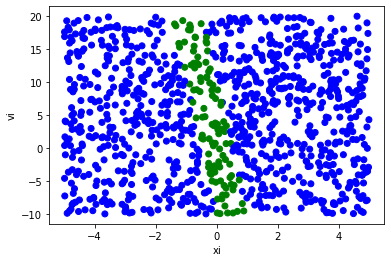

In [13]:
# define colors for each value of K
colors = {-1: 'red', 0: 'green', 1: 'blue'}

# create a scatter plot with xi and vi as x and y axes, and color the points according to K
plt.scatter(total_data_frame['xi'], total_data_frame['vi'], c=total_data_frame['K'].apply(lambda x: colors[x]))

# add axis labels
plt.xlabel('xi')
plt.ylabel('vi')

# show the plot
plt.show()